In [1]:
# based on tutorial:
# http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

In [2]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


In [4]:
# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 5e-2

In [5]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        p = 0.5
        if X[i - 3] == 1:
            p += 0.5
        if X[i - 8] == 1:
            p -= 0.25
        Y.append(0 if np.random.rand() > p else 1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Model

In [6]:
# Placeholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

# RNN inputs
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [7]:
# Definition of rnn_cell
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [8]:
# Adding rnn_cells to the graph
state = init_state
rnn_outputs = []

for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [9]:
# predictions, loss and training step

# logits and prediction
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

# losses and train step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit)
          for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(total_loss)

In [10]:
# train the network
def train_network(num_epochs, num_steps, state_size, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))

            if verbose:
                print('\nEPOCH', idx)

            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses, total_loss, final_state, train_step],
                             feed_dict = {x: X, y: Y, init_state: training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print('average loss at step ', step, training_loss / 100)
                    training_losses.append(training_loss / 100)
                    training_loss = 0
    return training_losses


EPOCH 0
average loss at step  100 0.651783311963
average loss at step  200 0.602998964787
average loss at step  300 0.555260771513
average loss at step  400 0.526330669522
average loss at step  500 0.521798354089
average loss at step  600 0.520632512271
average loss at step  700 0.519455341101
average loss at step  800 0.520941150188
average loss at step  900 0.520038294196

EPOCH 1
average loss at step  100 0.526802845001
average loss at step  200 0.518486346602
average loss at step  300 0.519092451036
average loss at step  400 0.520385197699
average loss at step  500 0.520486237705
average loss at step  600 0.520521895289
average loss at step  700 0.520220109224
average loss at step  800 0.520726292431
average loss at step  900 0.521282426417

EPOCH 2
average loss at step  100 0.527849881351
average loss at step  200 0.516263147891
average loss at step  300 0.519829786718
average loss at step  400 0.517850238979
average loss at step  500 0.517693577111
average loss at step  600 0.51

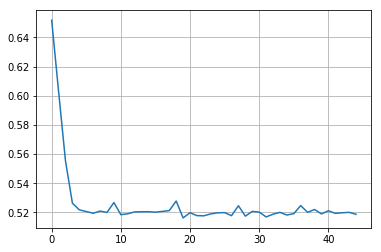

In [11]:
training_losses = train_network(num_epochs=5, num_steps=num_steps, state_size=state_size)
plt.plot(training_losses)
plt.grid()